# CZ4042: Neural Networks and Deep Learning Course Project
## Training Code of AI-Powered Game Bot to play RunLah

**Import Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import CenterCrop, Resize, Compose, ToTensor, Normalize
import torchvision.models
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import gc
import time

**Check for cuda availabity (recommend to run training properly)**

In [3]:
torch.cuda.is_available() # make sure this returns True

True

**Create Transformer**

In [4]:
# create image transformation pipeline for EfficientNet
# mean and std values: https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_v2_s.html#torchvision.models.efficientnet_v2_s
transformer = Compose([
    Resize((480,480), antialias=True),
    CenterCrop(480),
    Normalize(mean =[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225] )
])

**Create RunLahDataset**

In [5]:
class RunLahDataset(Dataset):
    def __init__(self, key_frame, image_directory, transform = None):
        # filenames and corresponding labels for images
        self.key_frame = key_frame

        # where images are found
        self.image_directory = image_directory

        # transform to be applied to images
        self.transform = transform

    # get number of image (aka len of dataset)
    def __len__(self):
        return len(self.key_frame)

    # load images and labels
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            # get index 
            idx = idx.to_list()

        # find image and label location
        name_of_image = os.path.join(self.image_directory, self.key_frame.iloc[idx,0])
        
        # load image
        image = Image.open(name_of_image)

        # convert image to tensor
        image = ToTensor()(image)

        # read label
        label = torch.tensor(self.key_frame.iloc[idx, 1])

        # apply transformation 
        if self.transform: 
            image = self.transform(image)

        return image, label

**Prerequisites: Batch Size declaration, Create train dataset and dataloader, test dataset and dataloader**

In [56]:
# import csv file with the labels of images
csv_labels = pd.read_csv("labels.csv") 

# split dataset into 8:2 train and test sets 
csv_train, csv_test = train_test_split(csv_labels, test_size = 0.2)  
df_train = pd.DataFrame(csv_train) 
df_test = pd.DataFrame(csv_test)

# set batch size to 2, 4 or 8
batch_size = 4

# create dataset and dataloader for train
ds_train = RunLahDataset(image_directory = "captures", key_frame = df_train, transform = transformer)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size = batch_size) 

# create dataset and dataloader for test
ds_test = RunLahDataset(image_directory = "captures", key_frame = df_test, transform = transformer)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size = batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


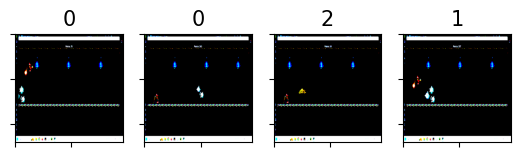

In [57]:
# create iterator for train dataset
iterate_dataset = iter(dl_train)
# get next item from the iterator
images, labels = next(iterate_dataset)

# create plot to see sample of images in train dataset
for img in range(len(images)):
        image_plot = plt.subplot(2, 4, img + 1)
        sample_image = (images[img].permute(1,2,0)*255.0).cpu()
        image_plot.set_xticklabels([])   
        image_plot.set_yticklabels([])  
        image_plot.set_title(labels[img].item(), fontsize=15)  
        plt.imshow(sample_image)        

#### The numbers on top of the images correspond to the following actions:
| Action  | Label |
|:-------:|:-----:|
|   Run   |   0   |
|   Jump  |   1   |
|   Duck  |   2   |

**Training Prerequisites: Model, Loss Function and Optimizer**

In [64]:
# set device to cuda (must be available)
device = "cuda" if torch.cuda.is_available() else "cpu"

# initialise EfficientNetV2-S model
model = torchvision.models.efficientnet_v2_s()

# out_features is 3 as we have 3 actions (seen in table above)
model.classifier = torch.nn.Linear(in_features = 1280, out_features = 3)
model = model.to(device)

# chosen loss function: Cross-Entropy Loss
criterion = torch.nn.CrossEntropyLoss()

# chosen optimizer: Stochastic Gradient Descent (SGD) with learning rate of 0.01 and momentum of 0.009
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.009)

**Training of Bot**

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [23:08<00:00,  1.48it/s]


[1] | loss: 0.465


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [20:35<00:00,  1.66it/s]


[2] | loss: 0.370


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:10<00:00,  2.25it/s]


[3] | loss: 0.332


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:13<00:00,  2.24it/s]


[4] | loss: 0.322


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:16<00:00,  2.24it/s]


[5] | loss: 0.310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:12<00:00,  2.25it/s]


[6] | loss: 0.304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [23:31<00:00,  1.45it/s]


[7] | loss: 0.297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:27<00:00,  2.21it/s]


[8] | loss: 0.287


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:05<00:00,  2.26it/s]


[9] | loss: 0.269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:04<00:00,  2.27it/s]


[10] | loss: 0.262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:06<00:00,  2.26it/s]


[11] | loss: 0.250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:03<00:00,  2.27it/s]


[12] | loss: 0.247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:05<00:00,  2.26it/s]


[13] | loss: 0.235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:02<00:00,  2.27it/s]


[14] | loss: 0.226


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:05<00:00,  2.27it/s]


[15] | loss: 0.218


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:02<00:00,  2.27it/s]


[16] | loss: 0.210


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:04<00:00,  2.27it/s]


[17] | loss: 0.200


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:02<00:00,  2.27it/s]


[18] | loss: 0.199


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:02<00:00,  2.27it/s]


[19] | loss: 0.186


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [15:01<00:00,  2.27it/s]


[20] | loss: 0.177

Training has completed!
Time Taken: 19463.696778059006


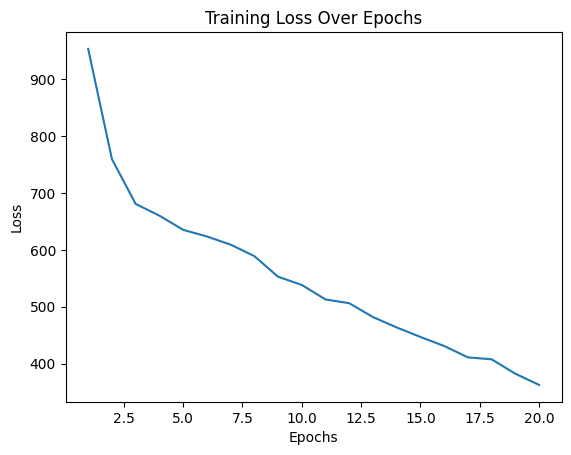

In [65]:
# set batch size to 10, 20 or 30
epochs = 20  

# list to store loss values after each epoch
list_loss = [] 

tr = time.time()

# iterate till the last epoch
for epoch in range(epochs):  
    # declare running loss
    run_loss = 0.0

    # load dataset in batches
    for data in tqdm(dl_train, position=0, leave=True):
        # get inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # compare outputs to target labels
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backpropagation
        loss.backward()

        # update the model's weights
        optimizer.step()

        run_loss += loss.item()

    # append run loss to list loss
    list_loss.append(run_loss)

    print(f'[{epoch + 1}] | loss: {run_loss / len(dl_train):.3f}')

    # reset running loss
    run_loss = 0.0

print('\nTraining has completed!')
print('Time Taken: ' + str(time.time() - tr))

# plot the loss curve
plt.plot(np.linspace(1, epochs, epochs).astype(int), list_loss)
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.title('Training Loss Over Epochs')  

# clean up the gpu memory 
gc.collect()
torch.cuda.empty_cache()

**Save the trained model**

In [66]:
PATH = 'efficientnet_s_20E_4BS.pth'
torch.save(model.state_dict(), PATH)

**Load the trained model for testing**

In [67]:
trained_model = torchvision.models.efficientnet_v2_s()
trained_model.classifier = torch.nn.Linear(in_features = 1280, out_features = 3)
trained_model.load_state_dict(torch.load(PATH))
trained_model = trained_model.to(device)
saved_mode = trained_model.eval()

**Test trained model on test dataset**

In [68]:
# keep track of correct and total predictions
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    # iterate test dataset
    for data in tqdm(dl_test):
        # get images and corresponding labels
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # get output
        outputs = trained_model(images)

        # convert model outputs to probabilities with softmax
        # argmax used to determine the predicted class for each image
        prediction = torch.softmax(outputs,dim = 1).argmax(dim = 1)

        # update total predictions 
        total_predictions += labels.size(0)

        # if the prediction matches the target label, update correct predictions
        correct_predictions += (prediction == labels).sum().item()

print(f'\n\n Accuracy of model on the test dataset: {100 * correct_predictions // total_predictions} %')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 513/513 [02:25<00:00,  3.54it/s]



 Accuracy of model on the test dataset: 90 %
